In [52]:
import numpy as np
import pandas as pd
import random
import copy
import os

from math import sqrt, log
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy.spatial
from haversine import haversine

import warnings
warnings.filterwarnings('ignore')

# Скачивание данных

Скачивание данных из файлов \
В файле "terminal_data_hackathon v4.xlsx" на странице "Incomes" названия колонок для приходов должны быть исключительно в формате даты без дополнительных символов

In [53]:
times = pd.read_csv(rf'./files/times v4.csv', sep=',')
lenght = pd.read_excel(rf'./files/terminal_data_hackathon v4.xlsx', sheet_name='TIDS')
income = pd.read_excel(rf'./files/terminal_data_hackathon v4.xlsx', sheet_name='Incomes')

income = income.set_index('TID')
lenght = lenght.set_index('TID')

random.seed(42)

Постройка матрицы расстояний на основе времени между банкоматами

In [54]:
distance_matrix = times.pivot_table(index = 'Origin_tid', columns = 'Destination_tid', values = 'Total_Time')
distance_matrix = distance_matrix.fillna(0)

# Визуализация

Визуализируем местонахождение банкоматов

In [55]:
class Visualisation:
    def __init__(self, df: pd.DataFrame, n_squares: int=4):
        self.df = df
        self.n_squares = n_squares


    @staticmethod
    def get_divisors(number):
        '''
            Поиск двух максимальных делителей числа
        '''
        result = {1, number}
        for divisor in range(2, number // 2  + 1):
            if number % divisor == 0:
                result.add(divisor)

        result = list(sorted(result))
        lenght_list = len(result)//2

        return result[lenght_list-1:lenght_list+1]
    

    def separation_to_squares(self, df: pd.DataFrame, n_squares: int=4) -> dict:
        '''
            if n_squares is not power of 2, separetion will be separate for bigger different of metrics
        '''
        if n_squares < 0:
            print('Separation number is negative')
            return {}
        
        north = df.longitude.max()
        south = df.longitude.min()
        east = df.latitude.max()
        west = df.latitude.min()

        result = dict()

        '''
            search divisors for separetion of square
        '''
        if n_squares ** .5 == int(n_squares ** .5):
            multiplies = [int(sqrt(n_squares))-1]*2
        else:
            multiplies = self.get_divisors(n_squares)
            if multiplies[0] == 1:
                print('Primal number!')
                return result

        '''
            determine the position vaertical or horizontal
        '''
        if (north - south) > (east - west):
            position = 'vertical'
        else:
            position = 'horizontal'


        minimal = multiplies[0]+1
        maximal = multiplies[1]+1
        if multiplies[0] != multiplies[1]:
            if (n_squares != 0) and (n_squares & (n_squares-1) == 0):
                    if position == 'vertical':
                        result['longitude'] = list(np.linspace(north, south, minimal))
                        result['latitude'] = list(np.linspace(east, west, maximal))
                    else:
                        result['longitude'] = list(np.linspace(east, west, maximal))
                        result['latitude'] = list(np.linspace(north, south, minimal))
            else:
                if position == 'vertical':
                    result['longitude'] = list(np.linspace(north, south, minimal))
                    result['latitude'] = list(np.linspace(east, west, maximal))
                else:
                    result['longitude'] = list(np.linspace(east, west, maximal))
                    result['latitude'] = list(np.linspace(north, south, minimal))
        else:
            if position == 'vertical':
                result['longitude'] = list(np.linspace(north, south, minimal+1))
                result['latitude'] = list(np.linspace(east, west, maximal+1))
            else:
                result['longitude'] = list(np.linspace(east, west, maximal+1))
                result['latitude'] = list(np.linspace(north, south, minimal+1))

        result['longitude'] = result['longitude'][1:-1]
        result['latitude'] = result['latitude'][1:-1]
        result['side'] = {'north': north, 'south': south, 'east': east, 'west': west}

        return result
    

    def visualisation_of_squares(self) -> dict:
        if self.n_squares < 0:
            print('Separation number is negative')
            return dict()
        multiplies = self.get_divisors(self.n_squares)
        if multiplies[0] == 1 and not (self.n_squares ** .5 == int(self.n_squares ** .5)):
            print('Primal number!')
            return dict()
        
        result = self.separation_to_squares(self.df, self.n_squares)

        fig, axes = plt.subplots(figsize=(12, 12))
        axes.scatter(data=self.df, x='latitude', y='longitude')

        for x in result['latitude']:
            axes.plot(np.array([x, x]), np.array([result['side']['south'], result['side']['north']]), color='red')

        for x in result['longitude']:
            axes.plot(np.array([result['side']['west'], result['side']['east']]), np.array([x, x]), color='red')
            
        axes.set_xlabel('latitude')
        axes.set_ylabel('longitude')

        return result

{'longitude': [37.67150887],
 'latitude': [55.608132735],
 'side': {'north': 39.84245897,
  'south': 35.50055877,
  'east': 56.75784253,
  'west': 54.45842294}}

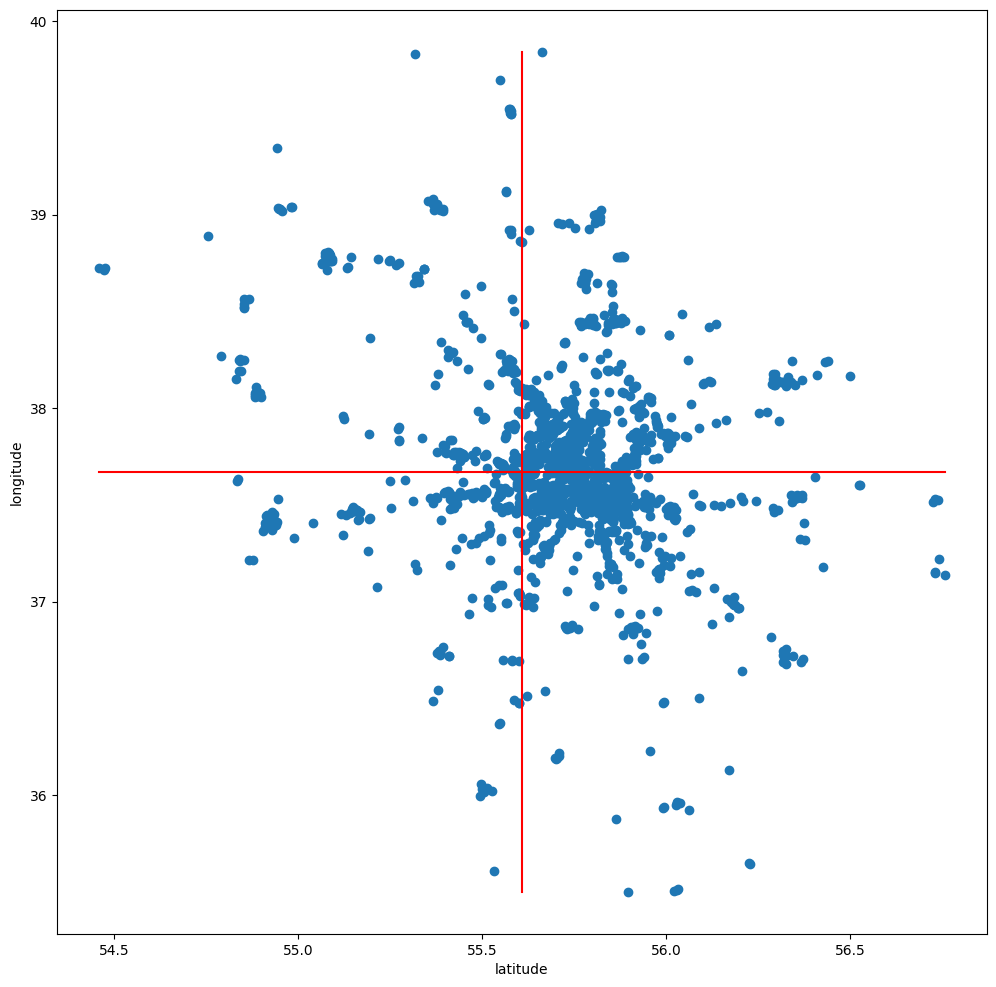

In [56]:
Visualisation(lenght, 4).visualisation_of_squares()

# Математическая модель разбития на категории

Задаем основные переменные.

In [57]:
model = copy.deepcopy(income) # экземпляр дата сета приходов
RUB = 10**6
days = 14
month_day = 30
downtime = 10
alfa = .95 # коэффициент аппроксимации

Рассчитываем модель с основными показателями.

In [58]:
tmp = list(income.columns)[1:]
model['sum'] = model[tmp].sum(axis=1)
model['mean'] = model[tmp].mean(axis=1)
model['std'] = model[tmp].std(axis=1)
model = model.drop(columns=tmp)

model['day'] = RUB/model['mean']
model['day_with_limit'] = np.where(model.day>14, 14, model.day)
model['number_trips'] = month_day/model.day_with_limit
model['limit'] = model['day_with_limit'].round(0)
model['quantity'] = 1

Определяем категории распределения точек по необходимому количеству поездок в месяц. 

In [59]:
pivotmodel2 = model.groupby(by='limit')[['quantity']].sum().reset_index()
pivotmodel2['loop'] = pivotmodel2.quantity / pivotmodel2.limit.max()
pivotmodel2['case_loop'] = pivotmodel2.limit.max() / pivotmodel2.limit
pivotmodel2['category'] = np.where(pivotmodel2.loop > 5, 'b', 'a')
pivotmodel2

,limit,quantity,loop,case_loop,category
0,1.0,1,0.071429,14.000000,a
1,2.0,1,0.071429,7.000000,a
2,3.0,2,0.142857,4.666667,a
3,4.0,3,0.214286,3.500000,a
4,5.0,11,0.785714,2.800000,a
5,6.0,19,1.357143,2.333333,a
6,7.0,22,1.571429,2.000000,a
7,8.0,39,2.785714,1.750000,a
8,9.0,36,2.571429,1.555556,a
9,10.0,38,2.714286,1.400000,a


Limit - определяет сколько раз нужно съездить в quantity банкоматов.\
Все точки, что должны быть обслужены, меньше чем за 14 дней будут отнесены к категории A.\
Далее будут включаться в маршрутные листы относительно показателя последнего обслуживания банкомата.

Добавляем к моделе показатель категории и переодичности поездок для категории A.

In [60]:
model = model.reset_index().merge(pivotmodel2[['limit', 'category']], on='limit', how='left')
model = model.set_index('TID')

# K-Means Classtering

Попытка класстеризовать точки категории B относитьльно необходимого количества поездок в месяц на основе расстояний между ними.

In [61]:
class Clastering():

    def __init__(self, df: pd.DataFrame, case: str, claster_limit: float, figsize: tuple=(5,3)):
        self.df = df
        self.case = case
        self.claster_limit = claster_limit
        self.__k = claster_limit+1
        self.figsize = figsize


    def distance(self, p1, p2):
        return haversine(p1[1:],p2[1:])
    

    def cluster_centroids(self, vals, clusters, k) -> list:
        results=[]
        for i in range(k):
            results.append(np.average(vals[clusters == i],weights=np.squeeze(np.asarray(vals[clusters == i][:,[0]])),axis=0))
        return results


    def kmeans(self, vals, k=None, centroids=None, steps=20):
        centroids = vals[np.random.choice(np.arange(len(vals)), k, False)]
        elbow = []
        for _ in range(max(steps, 1)):
            sqdists = scipy.spatial.distance.cdist(centroids, vals, lambda u, v: (self.distance(u,v)**2))
            elbow.append(sqdists)
            clusters = np.argmin(sqdists, axis=0)
            new_centroids = self.cluster_centroids(vals, clusters, k)
            if np.array_equal(new_centroids, centroids):
                break
            centroids = new_centroids
        return clusters, centroids, elbow


    def SSE(self) -> dict:
        vals = self.df[[self.case,'latitude','longitude']].values
        sse=[]
        data = {}
        try:
            for k in range(1,self.__k):
                clusters, centroids, elbow=self.kmeans(vals, k)
                sqdist = np.sum((elbow-np.mean(elbow))**2)
                sse.append(sqdist)
                data[k] = {'clusters': clusters, 'centroids': centroids, 'elbow': elbow}

            sse=sorted(sse,reverse=True)
            return {'sse': sse, 'data': data}
        except Exception:
            return self.SSE()

    def define_claster_limit(self, sse: list) -> list[int]:
        return [self.claster_limit, sse[self.claster_limit-1]]

    
    def visualisation_claster(self) -> dict:
        df = self.SSE()
        sse = df['sse']
        fig = plt.figure(figsize=(5,3))
        c = self.define_claster_limit(sse)
        x=list(range(1,self.__k))
        labels=x
        plt.plot(x,sse,'r')
        plt.scatter(x,sse,marker='x')
        plt.xticks(x, labels)
        plt.title('Elbow Method')
        plt.xlabel('K')
        plt.ylabel('SSE Distance')
        plt.plot([c[0], c[0]], [0, c[1]], color='green', linestyle='dashed', linewidth=2)  
        plt.show()
        df['clester_count'] = c[0]
        return df


    def selections(self):
        scce = self.visualisation_claster()
        data = scce['data'][scce['clester_count']]

        self.df['c']=[int(c) for c in data['clusters']]

        lats = [data['centroids'][i][1] for i in range(scce['clester_count'])]
        self.df['clat'] = self.df['c'].map(lambda x: lats[x])

        longs = [data['centroids'][i][2] for i in range(scce['clester_count'])]
        self.df['clong'] = self.df['c'].map(lambda x: longs[x])

        return self.df, scce
    

    @staticmethod
    def plot_clasters(df: pd.DataFrame, k: int) -> None:
        c_lat=list(set(df['clat']))
        c_long=list(set(df['clong']))

        fig, ax = plt.subplots(figsize=(10, 6))
        colors = ['gold', 'cornflowerblue', 'limegreen', 'violet', 'pink', 
                  'brown', 'salmon', 'aqua', 'olive', 'chocolate',
                  'indigo', 'orchid', 'silver', 'peru', 'navu']
        for x in range(k):
            x1=df.query(f'c=={x}')['latitude'].values.tolist()
            y1=df.query(f'c=={x}')['longitude'].values.tolist()
            plt.scatter(y1,x1, color=colors[x])
        plt.scatter(c_long,c_lat,marker='x', color='black')
        plt.show()
        

In [62]:
#A_category = lenght.merge(model.query('category == "a"')[['number_trips']], left_index=True, right_index=True, how='inner')
#B_category = lenght.merge(model.query('category == "b"')[['number_trips']], left_index=True, right_index=True, how='inner')

#A_category = Clastering(A_category, 'number_trips', 14)
#B_category = Clastering(B_category, 'number_trips', 14)

#A_category, scce = A_category.selections()
#Clastering.plot_clasters(A_category, scce['clester_count'])

#B_category, scce = B_category.selections()
#Clastering.plot_clasters(B_category, scce['clester_count'])

# K-Means Classtering add to model

In [63]:
# A_category = A_category.reset_index()
# B_category = B_category.reset_index()
model_added = copy.deepcopy(model)

In [64]:
# A_claster = times.merge(A_category[['TID', 'c']], left_on='Origin_tid', right_on='TID', how='left')
# A_claster = A_claster.merge(A_category[['TID', 'c']], left_on='Destination_tid', right_on='TID', how='left')

# B_claster = times.merge(B_category[['TID', 'c']], left_on='Origin_tid', right_on='TID', how='left')
# B_claster = B_claster.merge(B_category[['TID', 'c']], left_on='Destination_tid', right_on='TID', how='left')

In [65]:
# A_claster = A_claster.query('c_x==c_y').drop(columns=['TID_x', 'TID_y', 'c_y']).rename(columns={'c_x': 'cluster'})
# B_claster = B_claster.query('c_x==c_y').drop(columns=['TID_x', 'TID_y', 'c_y']).rename(columns={'c_x': 'cluster'})


In [66]:
# l = pd.DataFrame({
#       'Mean Time': A_claster.query(f'cluster=={x}').Total_Time.mean(), 
#       'Number of points': A_claster.query(f'cluster=={x}').drop_duplicates(subset='Origin_tid', keep='first').shape[0],
#       'Time %': (A_claster.query(f'cluster=={x}').drop_duplicates(subset='Origin_tid', keep='first').shape[0]/model.shape[0]) * A_claster.query(f'cluster=={x}').Total_Time.mean(),
#       'Number of cluster': x} for x in range(scce['clester_count']))
# print(l['Mean Time'].mean())
# print(l['Number of points'].sum())
# print(l['Number of points'].mean())
# l['Total time A'] = l['Mean Time'] * l['Number of points']
# l['Total time A / 720'] = l['Total time A'] / 720
# print(l['Total time A'].mean())
# print(l['Total time A / 720'].mean())
# print()
# print(l)

In [67]:
# l = pd.DataFrame({
#       'Mean Time': B_claster.query(f'cluster=={x}').Total_Time.mean(), 
#       'Number of points': B_claster.query(f'cluster=={x}').drop_duplicates(subset='Origin_tid', keep='first').shape[0],
#       'Time %': (B_claster.query(f'cluster=={x}').drop_duplicates(subset='Origin_tid', keep='first').shape[0]/model.shape[0]) * B_claster.query(f'cluster=={x}').Total_Time.mean(),
#       'Number of cluster': x} for x in range(1, 14))

# print(l['Mean Time'].mean())
# print(l['Number of points'].sum())
# print(l['Number of points'].mean())
# l['Total time B'] = l['Mean Time'] * l['Number of points']
# l['Total time B / 720'] = l['Total time B'] / 720
# print(l['Total time B'].mean())
# print(l['Total time B / 720'].mean())
# print()
# print(l)

In [68]:
# A_model = model_added.merge(A_claster.drop_duplicates(subset='Origin_tid', keep='first').set_index('Origin_tid')[['Total_Time', 'cluster']], left_index=True, right_index=True, how='inner')
# B_model = model_added.merge(B_claster.drop_duplicates(subset='Origin_tid', keep='first').set_index('Origin_tid')[['Total_Time', 'cluster']], left_index=True, right_index=True, how='inner')

In [69]:
# A_model['downtime'] = downtime * 60
# A_model['Common_Time'] = A_model[['Total_Time', 'downtime']].sum(axis=1)
# A_model['Car_per_minute'] = 20000/(12*60)
# A_model['Maintenance_cost_one_time'] = A_model['Common_Time']/60 * A_model['Car_per_minute']
# A_model['Maintenance_cost_per_month'] = A_model['number_trips'] * A_model['Maintenance_cost_one_time']
# A_model['Car_time'] = A_model['number_trips'] * A_model['Common_Time']/60
# ((A_model.Car_time.sum() / month_day) / (12*60)) * 20000 * 30

In [70]:
# B_model['downtime'] = downtime * 60
# B_model['Common_Time'] = B_model[['Total_Time', 'downtime']].sum(axis=1)
# B_model['Car_per_minute'] = 20000/(12*60)
# B_model['Maintenance_cost_one_time'] = B_model['Common_Time']/60 * B_model['Car_per_minute']
# B_model['Maintenance_cost_per_month'] = B_model['number_trips'] * B_model['Maintenance_cost_one_time']
# B_model['Car_time'] = B_model['number_trips'] * B_model['Common_Time']/60
# ((B_model.Car_time.sum() / month_day) / (12*60)) * 20000 * 30

# Функции для создания маршрутов

In [113]:
def build_routes(df, max_time, time: bool=False):
    points = list(df.columns)
    routes = []
    while points:
        current_time = 0
        route = [points.pop(0)]
        while points:
            # вычисление времени до следующей точки
            next_point = min(points, key=lambda point: df.loc[route[-1], point])
            next_time = df.loc[route[-1], next_point] + 10
            
            # если добавление следующей точки приведет к превышению максимального времени, 
            # завершим текущий маршрут и начнем новый
            if current_time + next_time > max_time:
                break
            
            route.append(next_point)
            points.remove(next_point)
            current_time += next_time

        
        if time:
            routes.append([route, [current_time]])
        else:
            routes.append(route)
        
    return routes


def routes_from_arr_points(category, distance_matrix, dir, start, reestr, every_route: bool=False, general_route: bool=True):
    reestr_ = copy.deepcopy(reestr)
    center = (category['longitude'].mean(), category['latitude'].mean())
    category['distance_to_center'] = np.sqrt((category['longitude'] - center[0]) ** 2 + (category['latitude'] - center[1]) ** 2)
    closest_point_index  = category.loc[[category['distance_to_center'].idxmin()]].to_dict('records')
    
    first_point = closest_point_index[0]['TID']

    set_points = list(set(category['TID']))
    set_points.pop(set_points.index(first_point))
    set_points.insert(0, first_point)
    
    
    df_distance = distance_matrix.loc[set_points, set_points]
    routes = build_routes(df_distance, 710)
    count = 1
    r = 0
    reestr_ = reestr_.rename(columns={'TID': 'Second'})
    
    arr_dfs = []
    for route in routes:
        if len(route) == 1:
            
            route = [{
                'First': route[0],
                'Second': route[0],
                'longitude1' : lenght.query(f'''TID == {route[0]}''').longitude.values[0],
                'latitude1' : lenght.query(f'''TID == {route[0]}''').latitude.values[0],
                'longitude2' : lenght.query(f'''TID == {route[0]}''').longitude.values[0],
                'latitude2' : lenght.query(f'''TID == {route[0]}''').latitude.values[0],
                'Total_Time' : 10,
                }]
            route = pd.DataFrame(route)
            
        else:
           
            
            route = pd.DataFrame({'First': route[:-1], 'Second': route[1:]})
            
            route = route.merge(times, left_on=['First', 'Second'], right_on=['Origin_tid','Destination_tid'])
            route = route.merge(lenght, left_on=['First'], right_on=['TID'])
            route = route.rename(columns = {'longitude':'longitude1', 'latitude':'latitude1'})
            route['Total_Time'] = route['Total_Time'] + 10
            
            route = route.merge(lenght, left_on=['Second'], right_on=['TID'])
            route = route.rename(columns = {'longitude':'longitude2', 'latitude':'latitude2'})

            route = route.drop(columns = ['Origin_tid', 'Destination_tid'])

        route['Idle'] = 10
        route['Delivery'] = route['Total_Time']-10
        route['Date'] = start
        route = route.astype({'Date': 'datetime64[ns]'})
        route = route.merge(reestr_[['Second', 'Date', 'Outcome']], on=['Second', 'Date'], how='left')
        route = route[['Date','First', 'Second', 'longitude1', 'latitude1', 'longitude2', 'latitude2', 'Total_Time', 'Idle', 'Delivery', 'Outcome']]
        r += route['Total_Time'].sum(axis=0)
        if every_route:
            route.to_excel(rf'{dir}/route_number_{count}.xlsx', index=False)
        
        route = route.to_dict('records')
        c_time = dt.datetime.combine(start, dt.time(9,10))
        
        res = [{
            'порядковый номер броневика': count,
            'устройство': route[0]['First'],
            'дата-время прибытия': c_time - dt.timedelta(minutes=10),
            'дата-время отъезда': c_time
        }]
        for line in route:
            d = {
                'порядковый номер броневика': count,
                'устройство': line['Second'] 
                }
            c_time += dt.timedelta(minutes = line['Delivery'])
            d['дата-время прибытия'] = c_time
            c_time += dt.timedelta(minutes = line['Idle'])
            d['дата-время отъезда'] = c_time
            res.append(d)
        arr_dfs.append(pd.DataFrame(res))
        count += 1

    if general_route:
        dir_ = rf'''./files/consolidated'''
        if not os.path.isdir(dir_):
            os.mkdir(dir_)
        
        pd.concat(arr_dfs).to_excel(f'''{dir_}/consolidated_report_{start.strftime('%d_%m_%Y')}.xlsx''', index=False)
    return [count-1, r, category.shape[0]]


def time_route(points, distance_matrix, lenght, k, x):
    points_  = copy.deepcopy(points)
    points_ = points_.rename(columns={'Id': 'TID'}).merge(lenght, on='TID', how='left')
    
    center = (points_['longitude'].mean(), points_['latitude'].mean())
    points_['distance_to_center'] = np.sqrt((points_['longitude'] - center[0]) ** 2 + (points_['latitude'] - center[1]) ** 2)
    closest_point_index  = points_.loc[[points_['distance_to_center'].idxmin()]].to_dict('records')
    
    first_point = closest_point_index[0]['TID']

    set_points = list(set(points_['TID']))
    set_points.pop(set_points.index(first_point))
    set_points.insert(0, first_point)
    df_distance = distance_matrix.loc[set_points, set_points]

    points = list(df_distance.columns)
    
    current_time = 0
    route = [points.pop(0)]
    while points:
        next_point = min(points, key=lambda point: df_distance.loc[route[-1], point])
        next_time = df_distance.loc[route[-1], next_point] + 10
        if current_time + next_time > k*710:
            return current_time + next_time
        
        route.append(next_point)
        points.remove(next_point)
        current_time += next_time

    return current_time

# Итоговая кластеризация

Кластеризация точек категории B относительно затраченного времени на объезд всех точек по 14 категориям.\
Были взяты 14 категорий, так как неодходимо обслуживать банкоматы раз в 14 дней.\
Такое распределение сделано для того, чтобы снизить нагрузку.

1420*(1+ (1 - alfa)) -> берется значение рабочего дня 720, вычитается из него 10 минут (применим такой расчет, так как для расчета последующего пути не должны быть учтены 10 минут инкассирования на первой точке). Далее, время маршрута умножается на количество категорий, в нашем случае их 2: A - быстрозаполняемые банкоматы, B - медленнозаполняемые банкоматы. Потом добавляется дополнительное время, расчитанное как (((время рабочего дня) - (затраты инкассирования первой точки)) * (количество категорий)) * (обратный коэффициент аппроксимации + 1).

In [72]:
points = list(model.reset_index().query('category == "b"').drop_duplicates(subset='TID', keep='first').TID)
B_points= build_routes(distance_matrix.loc[points, points], 1420*(1+ (1 - alfa)), True)

Формирование дата сета B категории.

In [73]:
B_category = pd.DataFrame([])
for x in range(1, len(B_points)+1):
    B_category = pd.concat([B_category, pd.DataFrame({'TID': B_points[x-1][0], 'cluster': x, 'Cluster_time': B_points[x-1][-1]*len(B_points[x-1][0])})])

Просмотр полученных данных.

In [74]:
B_category_pivot = copy.deepcopy(B_category)
B_category_pivot['Number_points_in_cluster'] = 1
B_category_pivot = B_category_pivot.pivot_table(index=['cluster', 'Cluster_time'], values='Number_points_in_cluster', aggfunc='count')
B_category_pivot

,,Number_points_in_cluster
cluster,Cluster_time,
1,1489.64,114
2,1481.42,115
3,1485.20,107
4,1483.43,114
5,1482.80,87
6,1488.38,88
7,1482.04,96
8,1487.69,77
9,1483.02,94


# Формирование реестра маршрутов

In [75]:
AB_income = B_category.set_index('TID')[['cluster']].merge(income, left_index=True, right_index=True, how='right')
A_income_tmp = AB_income.fillna(-1).query('cluster == -1')
B_income_tmp = AB_income.fillna(-1).query('cluster != -1')

In [76]:
income.columns = pd.to_datetime(income.columns).date
AB_income = B_category.set_index('TID')[['cluster']].merge(income, left_index=True, right_index=True, how='right')
A_income = AB_income.fillna(-1).query('cluster == -1')
B_income = AB_income.fillna(-1).query('cluster != -1')

A_income = model.query('category == "a"')[['mean', 'std', 'limit', 'category']].merge(A_income, left_index=True, right_index=True, how='left')
B_income = model.query('category == "b"')[['mean', 'std', 'limit', 'category']].merge(B_income, left_index=True, right_index=True, how='left')

start = B_income.columns[5]

In [77]:
AB_income = pd.concat([A_income, B_income], axis=0)
AB_residue = AB_income[[start, 'limit', 'cluster', 'mean', 'std', 'category']].reset_index()
AB_residue['Date'] = start
AB_residue['Number_day'] = 0
AB_residue = AB_residue.rename(columns={start: 'Balance_close'})
reestr = pd.DataFrame([], columns=['TID', 'limit', 'cluster', 'Balance_open', 'Income', 'Outcome', 'Balance_close', 'Date', 'Number_day_form_last_serves', 'Number_day', 'mean', 'std', 'category'])
reestr = pd.concat([reestr, AB_residue]).fillna(0)
reestr = reestr.reset_index(drop=True).astype({'cluster': 'int64', 'limit': 'int64', 'Number_day': 'int64', 'Number_day_form_last_serves': 'int64', 'Date': 'datetime64[ns]', 'Balance_open': 'int64'})

In [78]:
# A_residue = A_income[[start, 'limit', 'cluster', 'mean', 'std', 'category']].reset_index()
# A_residue['Date'] = start
# A_residue['Number_day'] = 0
# A_residue = A_residue.rename(columns={start: 'Balance_close'})
# A_reestr = pd.DataFrame([], columns=['TID', 'limit', 'cluster', 'Balance_open', 'Income', 'Outcome', 'Balance_close', 'Date', 'Number_day_form_last_serves', 'Number_day', 'mean', 'std', 'category'])
# A_reestr = pd.concat([A_reestr, A_residue]).fillna(0)

In [79]:
# B_residue = B_income[[start, 'limit', 'cluster', 'mean', 'std', 'category']].reset_index()
# B_residue['Date'] = start
# B_residue['Number_day'] = 0
# B_residue = B_residue.rename(columns={start: 'Balance_close'})
# B_reestr = pd.DataFrame([], columns=['TID', 'limit', 'cluster', 'Balance_open', 'Income', 'Outcome', 'Balance_close', 'Date', 'Number_day_form_last_serves', 'Number_day', 'mean', 'std', 'category'])
# B_reestr = pd.concat([B_reestr, B_residue]).fillna(0)

### Depends on points' number

In [80]:
if False:
    counter = B_income.shape[0]//(14)
    A_counter = A_income.shape[0]//(14)
    for x in list(B_income.columns)[4:]:
        lastday_tmp = x-dt.timedelta(days=1)

        # B category
        B_income_tmp = B_income[[x]].reset_index().rename(columns={x: 'Income'})

        
        B_nextday_tmp = B_reestr.query(f'Date == @lastday_tmp')
        B_nextday_tmp['Date'] += dt.timedelta(days=1)
        B_nextday_tmp = B_nextday_tmp.drop(columns='Income').merge(B_income_tmp, on='TID', how='inner')

        B_nextday_tmp['Balance_open'] = B_nextday_tmp['Balance_close']
        B_nextday_tmp['Balance_close'] = 0

        B_nextday_tmp['Number_day'] += 1
        B_nextday_tmp['Number_day_form_last_serves'] += 1


        B_nextday_tmp['Outcome'] = np.where(((B_nextday_tmp.Balance_open >= RUB) | 
                                            (B_nextday_tmp.Number_day == B_nextday_tmp.cluster) | 
                                            (B_nextday_tmp.Number_day_form_last_serves > 14)) & 
                                            (RUB*(A_income.shape[0]/B_income.shape[0]) <  B_nextday_tmp.Balance_open), 
                                            B_nextday_tmp.Balance_open, 0)

        #((B_nextday_tmp['mean'] + B_nextday_tmp['std'])*2 < B_nextday_tmp.Balance_open)
        #(RUB*(A_income.shape[0]/B_income.shape[0]) < B_nextday_tmp.Balance_open)
        B_nextday_tmp['Number_day'] = np.where((B_nextday_tmp.Number_day > 14), 1, B_nextday_tmp.Number_day)
        B_nextday_tmp['Number_day_form_last_serves'] = np.where((B_nextday_tmp.Outcome != 0), 1, B_nextday_tmp.Number_day_form_last_serves)
        
        B_nextday_tmp['Balance_close'] = B_nextday_tmp.Balance_open + B_nextday_tmp.Income - B_nextday_tmp.Outcome

        B_reestr = pd.concat([B_reestr, B_nextday_tmp]).fillna(0).reset_index(drop=True)

        limit = B_reestr.query('Date == @x and Outcome != 0').shape[0]
        if limit < counter:
            potencial = list(B_reestr.query(f'Date == @x and Outcome == 0 and cluster == {int(int(x.day)%14)+1}').sort_values(by='Balance_open', ascending=False).Id)[:int(counter-limit)]
            if potencial != []:
                B_reestr.loc[(B_reestr.Date == x) & 
                            (B_reestr.TID.isin(potencial)), 'Outcome'] = B_reestr.Balance_open
                B_reestr.loc[(B_reestr.TID.isin(potencial)) & (B_reestr.Date == x), 'Balance_close'] = B_nextday_tmp.Balance_open + B_nextday_tmp.Income - B_nextday_tmp.Outcome
                B_reestr.loc[(B_reestr.TID.isin(potencial)) & (B_reestr.Date == x), 'Number_day'] = 1
                B_reestr.loc[(B_reestr.TID.isin(potencial)) & (B_reestr.Date == x), 'Number_day_form_last_serves'] = 1

        # A category
        A_income_tmp = A_income[[x]].reset_index().rename(columns={x: 'Income'})
        
        A_nextday_tmp = A_reestr.query(f'Date == @lastday_tmp')
        A_nextday_tmp['Date'] += dt.timedelta(days=1)
        A_nextday_tmp = A_nextday_tmp.drop(columns='Income').merge(A_income_tmp, on='TID', how='inner')

        A_nextday_tmp['Balance_open'] = A_nextday_tmp['Balance_close']
        A_nextday_tmp['Balance_close'] = 0

        A_nextday_tmp['Number_day'] += 1
        A_nextday_tmp['Number_day_form_last_serves'] += 1


        A_nextday_tmp['Outcome'] = np.where(((A_nextday_tmp.Balance_open >= RUB) | 
                                            (A_nextday_tmp.Number_day_form_last_serves == A_nextday_tmp.cluster) | 
                                            (A_nextday_tmp.Number_day_form_last_serves > 14)) & 
                                            (RUB*(1-(A_income.shape[0]/B_income.shape[0])) <  A_nextday_tmp.Balance_open), 
                                            A_nextday_tmp.Balance_open, 0)
        #((A_nextday_tmp['mean'] + 2 * A_nextday_tmp['std'])*2 < A_nextday_tmp.Balance_open)
        #(RUB*(1-(A_income.shape[0]/B_income.shape[0])) <  A_nextday_tmp.Balance_open)
        A_nextday_tmp['Number_day'] = np.where((A_nextday_tmp.Number_day > 14), 1, A_nextday_tmp.Number_day)
        A_nextday_tmp['Number_day_form_last_serves'] = np.where((A_nextday_tmp.Outcome != 0), 1, A_nextday_tmp.Number_day_form_last_serves)
        
        A_nextday_tmp['Balance_close'] = A_nextday_tmp.Balance_open + A_nextday_tmp.Income - A_nextday_tmp.Outcome

        A_reestr = pd.concat([A_reestr, A_nextday_tmp]).fillna(0).reset_index(drop=True)


        limit = A_reestr.query('Date == @x and Outcome != 0').shape[0]
        if limit < A_counter:
            potencial = list(A_reestr.query(f'Date == @x and Outcome == 0 and cluster == {int(int(x.day)%14)+1}').sort_values(by='Balance_open', ascending=False).Id)[:int(counter-limit)]
            if potencial != []:
                A_reestr.loc[(A_reestr.Date == x) & 
                            (A_reestr.TID.isin(potencial)), 'Outcome'] = A_reestr.Balance_open
                A_reestr.loc[(A_reestr.TID.isin(potencial)) & (A_reestr.Date == x), 'Balance_close'] = A_nextday_tmp.Balance_open + A_nextday_tmp.Income - A_nextday_tmp.Outcome
                A_reestr.loc[(A_reestr.TID.isin(potencial)) & (A_reestr.Date == x), 'Number_day'] = 1
                A_reestr.loc[(A_reestr.TID.isin(potencial)) & (A_reestr.Date == x), 'Number_day_form_last_serves'] = 1
    reestr = pd.concat([A_reestr, B_reestr])
    reestr.to_excel(rf'./files/reestr.xlsx', index=False)
    A_reestr.to_excel(rf'./files/A_reestr_test.xlsx', index=False)
    B_reestr.to_excel(rf'./files/B_reestr_test.xlsx', index=False)

### Depends on time

In [81]:
income_tmp = pd.concat([A_income, B_income]).reset_index()
# reestr = pd.concat([A_reestr, B_reestr]).reset_index(drop=True).astype({'cluster': 'int64', 
#                                                                         'limit': 'int64', 
#                                                                         'Number_day': 'int64', 
#                                                                         'Number_day_form_last_serves': 'int64', 
#                                                                         'Date': 'datetime64[ns]', 'Balance_open': 'int64'})

if True:
    for x in list(B_income.columns)[6:]:
        lastday_tmp = x-dt.timedelta(days=1)
        AB_nextday_tmp = reestr.query(f'Date == @lastday_tmp')

        AB_nextday_tmp['Date'] += dt.timedelta(days=1)
        AB_nextday_tmp = AB_nextday_tmp.drop(columns='Income').merge(income_tmp[['TID', x]].rename(columns={x: 'Income'}), on='TID', how='inner')

        AB_nextday_tmp['Balance_open'] = AB_nextday_tmp['Balance_close']
        AB_nextday_tmp['Balance_close'] = 0
        AB_nextday_tmp['Outcome'] = 0

        AB_nextday_tmp['Number_day'] += 1
        AB_nextday_tmp['Number_day_form_last_serves'] += 1

        # ((RUB*(A_income.shape[0]/B_income.shape[0]) <  AB_nextday_tmp.Balance_open)) & 
        # ((RUB*(1-(A_income.shape[0]/B_income.shape[0])) <  AB_nextday_tmp.Balance_open)) &

        AB_nextday_tmp['Outcome'] = np.where((AB_nextday_tmp.Number_day == AB_nextday_tmp['cluster']) & (AB_nextday_tmp.category == 'b'), AB_nextday_tmp.Balance_open, AB_nextday_tmp.Outcome)
        
        AB_nextday_tmp['Outcome'] = np.where((AB_nextday_tmp.Number_day_form_last_serves == AB_nextday_tmp['limit']) & (AB_nextday_tmp.category == 'a'), AB_nextday_tmp.Balance_open, AB_nextday_tmp.Outcome)
        
        AB_nextday_tmp['Outcome'] = np.where((AB_nextday_tmp.Number_day_form_last_serves > 14) | (AB_nextday_tmp.Balance_open >= RUB), AB_nextday_tmp.Balance_open, AB_nextday_tmp.Outcome)
        

        AB_nextday_tmp['Number_day'] = np.where((AB_nextday_tmp.Number_day > 14), 1, AB_nextday_tmp.Number_day)
        AB_nextday_tmp['Number_day_form_last_serves'] = np.where((AB_nextday_tmp.Outcome != 0), 1, AB_nextday_tmp.Number_day_form_last_serves)
        
        AB_nextday_tmp['Balance_close'] = AB_nextday_tmp.Balance_open + AB_nextday_tmp.Income - AB_nextday_tmp.Outcome

        reestrday_tmp = AB_nextday_tmp.query(f'Date == @x').reset_index(drop=True)
        
        # Overload  and (Number_day_form_last_serves != limit + 1 or Number_day_form_last_serves != limit - 1)
        while True:
            offer = copy.deepcopy(reestrday_tmp).reset_index(drop=True)
            if not offer.query(f'Date == @x and Outcome != 0 and category == "a"')[['TID']].empty:
                if time_route(offer.query(f'Date == @x and Outcome != 0 and category == "a"')[['TID']], distance_matrix, lenght, 2*710, x) < 2*710*(1+(1-alfa)):
                    potencial = reestrday_tmp.query(f'Date == @x and Outcome == 0 and category == "a"').sort_values(by='Balance_open', ascending=False) 
                    potencial = list(potencial.head(1).TID)
                    if potencial != []:
                        reestrday_tmp.loc[(reestrday_tmp.TID.isin(potencial)), 'Outcome'] = reestrday_tmp.Balance_open
                        reestrday_tmp.loc[(reestrday_tmp.TID.isin(potencial)), 'Balance_close'] = reestrday_tmp.Balance_open + reestrday_tmp.Income - reestrday_tmp.Outcome
                        reestrday_tmp.loc[(reestrday_tmp.TID.isin(potencial)), 'Number_day'] = 1
                        reestrday_tmp.loc[(reestrday_tmp.TID.isin(potencial)), 'Number_day_form_last_serves'] = 1
                    else:
                        break
                else:
                    break
            else:
                break
        # here
        reestr = pd.concat([reestr, offer]).astype({'cluster': 'int64', 'limit': 'int64', 'Number_day': 'int64', 'Number_day_form_last_serves': 'int64', 'Date': 'datetime64[ns]', 'Balance_open': 'int64'})
        
    reestr.to_excel(rf'./files/reestr.xlsx', index=False)

In [82]:
pivot = pd.read_excel(rf'./files/reestr.xlsx')
pivot['signal'] = np.where(pivot.Outcome != 0, 1, np.nan)
pivot = pivot.pivot_table(index='Date', values='signal', aggfunc='sum')
pivot.to_excel(rf'./files/pivot_test.xlsx')
pivot.sort_values(by='signal', ascending=False)

,signal
Date,
2022-11-12,165.0
2022-09-18,163.0
2022-09-15,162.0
2022-11-27,162.0
2022-10-27,162.0
...,...
2022-09-14,84.0
2022-10-26,80.0
2022-10-12,80.0


# Статистика и создание маршрутных листов на основе реестра поездаок

In [114]:
tmp = copy.deepcopy(lenght.reset_index())
start = dt.date(2022, 9, 1)
end = dt.date(2022, 11, 30)
stat = pd.DataFrame([])
l = []
while start <= end:
    
    lenght_tmp = tmp.loc[tmp.TID.isin(list(reestr.query('Date == @start and Outcome !=0').TID))]
    dir = rf'''./files/{start.strftime('%d_%m_%Y')}'''
    if not os.path.isdir(dir):
        os.mkdir(dir)
    if not lenght_tmp.empty:
        list_tmp = routes_from_arr_points(lenght_tmp, distance_matrix, dir, start, reestr)
        l.append(list_tmp[0])
    
    route_tmp = reestr.query('Date == @start')
    Balance_open = route_tmp.Balance_open.sum(axis=0)
    Income = route_tmp.Income.sum(axis=0)
    Outcome = route_tmp.Outcome.sum(axis=0)
    Balance_close = Balance_open + Income - Outcome
    Cost_balance = round((Balance_close * .02)/365, 2)
    Cost_collection = Outcome * .0001 if Outcome > 10**5 else 100

    Number_of_routes = list_tmp[0] #кол-во маршрутов в день - расчетать
    Cost_car = Number_of_routes * 10**4 * 2
    Total_cost = Cost_balance + Cost_collection + Cost_car

    Number_of_points = list_tmp[2] #кол-во точек по всем маршрутам
    Total_time_per_day = list_tmp[1] # затраченное время на маршрут


    stat = pd.concat([
        stat,
        pd.DataFrame([{
            'Date': start,
            'Balance_open': Balance_open,
            'Income': Income,
            'Outcome': Outcome,
            'Balance_close': Balance_close,
            'Cost_balance': Cost_balance, # затраты на неинкассированный остаток
            'Cost_collection': Cost_collection, # затраты на инкассацию
            'Cost_car': Cost_car,
            'Total_cost': Total_cost,
            'Number_of_routes': Number_of_routes,
            'Number_of_points': Number_of_points,
            'Total_time_per_day': Total_time_per_day, 

        }])
    ])
 
    start += dt.timedelta(days=1)
stat['Cost_car'] = 20000 * stat.Number_of_routes.max()
stat.Total_cost = stat.Cost_balance + stat.Cost_collection + stat.Cost_car
stat.to_excel(f'Stats_per_day.xlsx', index=False)

In [115]:
def create_report_routes():
    files = os.listdir(rf'''./files/consolidated''')
    arr_dfs = []
    for file in files:
        arr_dfs.append(pd.read_excel(rf'''./files/consolidated/{file}'''))
        os.remove(rf'''./files/consolidated/{file}''')
    return pd.concat(arr_dfs).reset_index(drop=True)

# Создание отчетов на основе реестра поездок

In [ ]:
create_report_routes().to_excel(rf'./files/Маршруты.xlsx', index=False, sheet_name='Маршруты')

In [ ]:
reestr = pd.read_excel(rf'./files/reestr.xlsx')

start = dt.date(2022, 9, 1)
end = dt.date(2022, 11, 30)

residue_per_day = copy.deepcopy(reestr.query('Date == @start')[['TID']])
cost_balance_per_day = copy.deepcopy(reestr.query('Date == @start')[['TID']])
collection_per_day = copy.deepcopy(reestr.query('Date == @start')[['TID']])

while start <= end:
    reestr_tmp = reestr.query('Date == @start')
    residue_per_day_tmp = copy.deepcopy(reestr_tmp[['TID', 'Outcome', 'Balance_close']])
    cost_balance_per_day_tmp = copy.deepcopy(reestr_tmp[['TID', 'Balance_close']])
    collection_per_day_tmp = copy.deepcopy(reestr_tmp[['TID', 'Outcome']])

    residue_per_day_tmp['Signal'] = np.where(residue_per_day_tmp.Outcome != 0, residue_per_day_tmp.Balance_close, 0)
    cost_balance_per_day_tmp.Balance_close = cost_balance_per_day_tmp.Balance_close.apply(lambda x: round((x * .02)/365, 2))
    collection_per_day_tmp.Outcome = collection_per_day_tmp.Outcome.apply(lambda x: x * .01 if x > 10**5 else 100)

    residue_per_day = residue_per_day.merge(residue_per_day_tmp[['TID', 'Signal']].rename(columns={'Signal': start}), on='TID', how='left')
    cost_balance_per_day = cost_balance_per_day.merge(cost_balance_per_day_tmp.rename(columns={'Balance_close': start}), on='TID', how='left')
    collection_per_day = collection_per_day.merge(collection_per_day_tmp.rename(columns={'Outcome': start}), on='TID', how='left')

    start += dt.timedelta(days=1)


residue_per_day.to_excel(rf'./files/Остатки_на_конец_дня.xlsx', index=False, sheet_name='Остатки_на_конец_дня')
cost_balance_per_day.to_excel(rf'./file/sCтоимость_фондирования.xlsx', index=False, sheet_name='Cтоимость_фондирования')
collection_per_day.to_excel(rf'./files/Стоимость_инкасации.xlsx', index=False, sheet_name='Стоимость_инкасации')


residue_per_day_tmp = copy.deepcopy(residue_per_day)
cost_balance_per_day_tmp = copy.deepcopy(cost_balance_per_day)
collection_per_day_tmp = copy.deepcopy(collection_per_day)


residue_per_day_tmp.TID = 'Остатки_на_конец_дня'
cost_balance_per_day_tmp.TID = 'Cтоимость_фондирования'
collection_per_day_tmp.TID = 'Стоимость_инкасации'


residue_per_day_tmp = residue_per_day_tmp.groupby(by='TID').sum().reset_index()
cost_balance_per_day_tmp = cost_balance_per_day_tmp.groupby(by='TID').sum().reset_index()
collection_per_day_tmp = collection_per_day_tmp.groupby(by='TID').sum().reset_index()


total = pd.concat([residue_per_day_tmp, cost_balance_per_day_tmp, collection_per_day_tmp])
total.loc[len(total.index)] = ['Итог'] + list(total[list(total.columns)[1:]].sum(axis=0))


total.rename(columns={'TID': 'Cтатья_расходов'}).to_excel(rf'./files/Итог.xlsx', index=False, sheet_name='Итог')